## Import Library

In [252]:
import math
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

## Data Understanding

In [253]:
# Read Dataset
df_customer = pd.read_csv('dataset/customer.csv', delimiter=';')
df_product = pd.read_csv('dataset/product.csv', delimiter=';')
df_store = pd.read_csv('dataset/store.csv', delimiter=';')
df_transaction = pd.read_csv('dataset/transaction.csv', delimiter=';')

In [254]:
# Menampilkan 5 data teratas dari data customer
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [255]:
# Menampilkan 5 data teratas dari data product
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [256]:
# Menampilkan 5 data teratas dari data store
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [257]:
# Menampilkan 5 data teratas dari data transaction
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [258]:
# Melakukan data cleansing
df_customer['Income'] = df_customer['Income'].replace('[,]', '.', regex=True).astype('float')
df_store['Latitude'] = df_store['Latitude'].replace('[,]', '.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]', '.', regex=True).astype('float')

In [259]:
# Mengubah format date
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format="%d/%m/%Y")

In [260]:
# Merge Dataset
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product, on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [261]:
# Menampilkan informasi attribut
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  4976 non-null   object        
 11  Income          5020 non-null   float64       
 12  Product Name    5020 non-null   object        
 13  Price_y         5020 non-null   int64         
 14  StoreName       5020 non-null   object        
 15  Grou

In [262]:
# Mengecek missing value
print('Jumlah missing value untuk setiap kolom')
df_merge.isnull().sum()

Jumlah missing value untuk setiap kolom


TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price_x            0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
Product Name       0
Price_y            0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
dtype: int64

In [263]:
# Mengecek data duplicate
duplicate_count = df_merge.duplicated().sum()
print(f"Jumlah data duplikat secara keseluruhan: {duplicate_count}")

Jumlah data duplikat secara keseluruhan: 0


In [264]:
# Menampilkan correlation matrix
df_merge.corr(numeric_only=True)

,CustomerID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Income,Price_y,Latitude,Longitude
CustomerID,1.000000,-0.016423,-0.009755,-0.024915,0.004129,-0.025952,-0.009947,0.005783,-0.016423,0.002278,-0.003122
Price_x,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001196,1.000000,-0.029008,0.018652
Qty,-0.009755,-0.353640,1.000000,0.621129,0.014365,-0.027768,-0.010542,-0.028425,-0.353640,-0.004170,0.004807
TotalAmount,-0.024915,0.440632,0.621129,1.000000,-0.010722,-0.016900,-0.008774,-0.025350,0.440632,-0.029938,0.025437
StoreID,0.004129,-0.032863,0.014365,-0.010722,1.000000,-0.003872,-0.000189,0.001613,-0.032863,0.471852,-0.094943
Age,-0.025952,0.014693,-0.027768,-0.016900,-0.003872,1.000000,-0.033183,0.486692,0.014693,0.009266,0.015951
Gender,-0.009947,0.010705,-0.010542,-0.008774,-0.000189,-0.033183,1.000000,-0.071443,0.010705,-0.006051,-0.001183
Income,0.005783,0.001196,-0.028425,-0.025350,0.001613,0.486692,-0.071443,1.000000,0.001196,0.015518,0.004385
Price_y,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001196,1.000000,-0.029008,0.018652
Latitude,0.002278,-0.029008,-0.004170,-0.029938,0.471852,0.009266,-0.006051,0.015518,-0.029008,1.000000,-0.395995


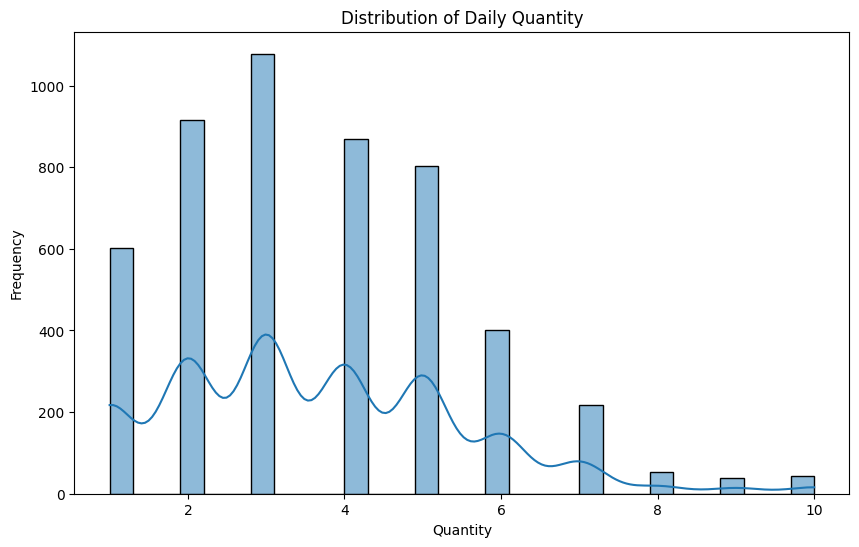

In [265]:
# Distribusi Jumlah Quantity
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merge, x='Qty', bins=30, kde=True)
plt.title('Distribution of Daily Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

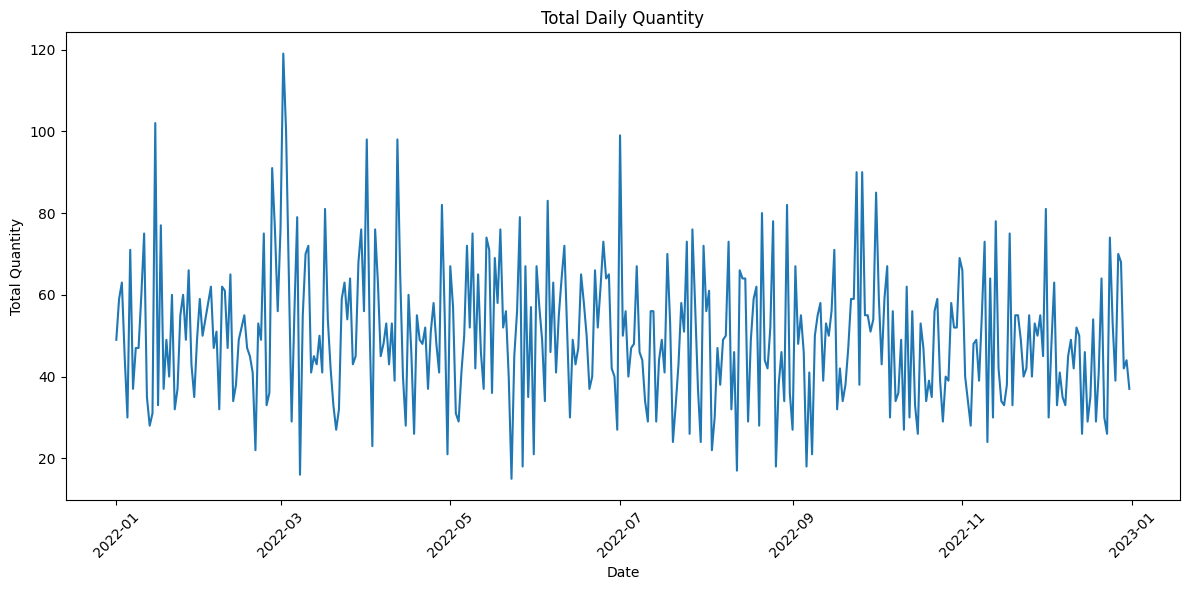

In [266]:
# Menampilkan grafik total quantity per hari
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Qty', data=df_merge.groupby('Date')['Qty'].sum().reset_index())
plt.title('Total Daily Quantity')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

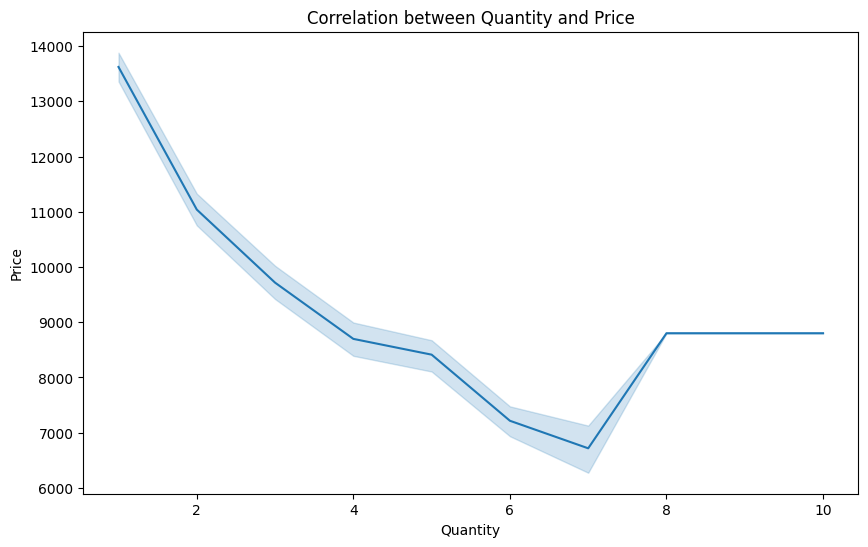

In [267]:
# Korelasi antara Quantity dengan Harga
plt.figure(figsize=(10, 6))
sns.lineplot(x='Qty', y='Price_x', data=df_merge)
plt.title('Correlation between Quantity and Price')
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.show()

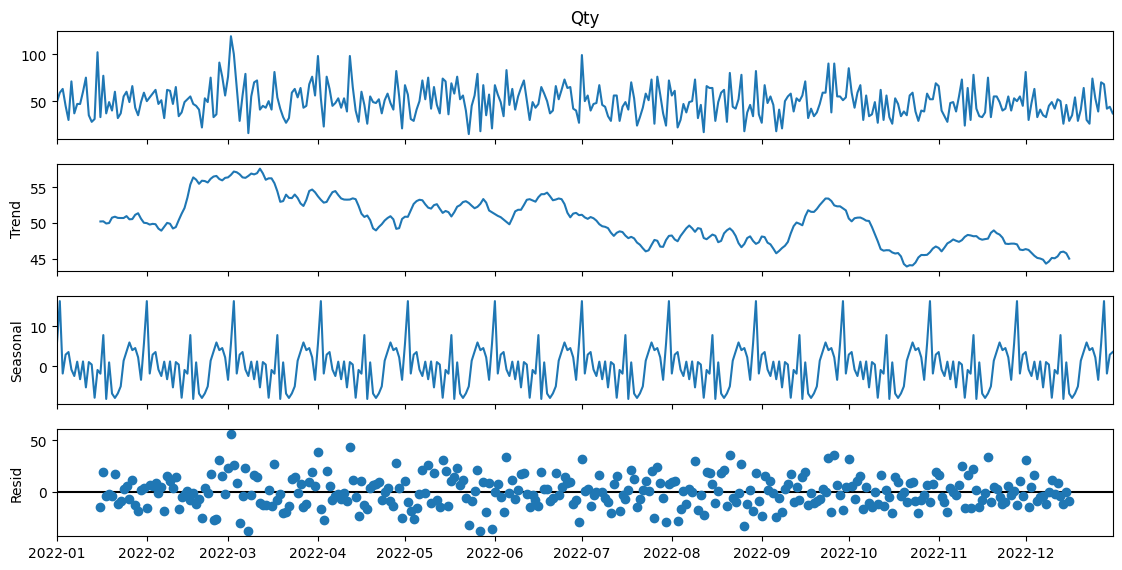

In [268]:
# Decompose Time Series
decomposition = seasonal_decompose(df_merge.groupby('Date')['Qty'].sum(), period=30)  # Misalnya, periode musiman 30 hari
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

## Data Preparation

In [269]:
# Menghilangkan missing value
df_merge = df_merge.dropna()

In [270]:
# Membuat data frame baru untuk time series
df = df_merge.groupby(['Date'])['Qty'].sum().reset_index()
df = df.set_index('Date')
df.sort_values('Date')

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,28
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


In [271]:
# Pisahkan data untuk pelatihan dan pengujian
train_size = int(0.7 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

In [272]:
# # Inisialisasi scaler
# scaler = MinMaxScaler()

# # Normalisasi data
# train_data_normalized = scaler.fit_transform(train_data)
# test_data_normalized = scaler.transform(test_data)

# # Konversi kembali ke DataFrame setelah normalisasi
# train_data_normalized = pd.DataFrame(train_data_normalized, columns=train_data.columns, index=train_data.index)
# test_data_normalized = pd.DataFrame(test_data_normalized, columns=test_data.columns, index=test_data.index)

## Modeling

In [273]:
# Test Augmented Dickey-Fuller untuk menguji data stasioner atau tidak
result = adfuller(df['Qty'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])        # p-value < 0.05 -> hipotesis nol diterima & deret ini dianggap stasioner => d = 0
print('Critical Values:')           
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.248302
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


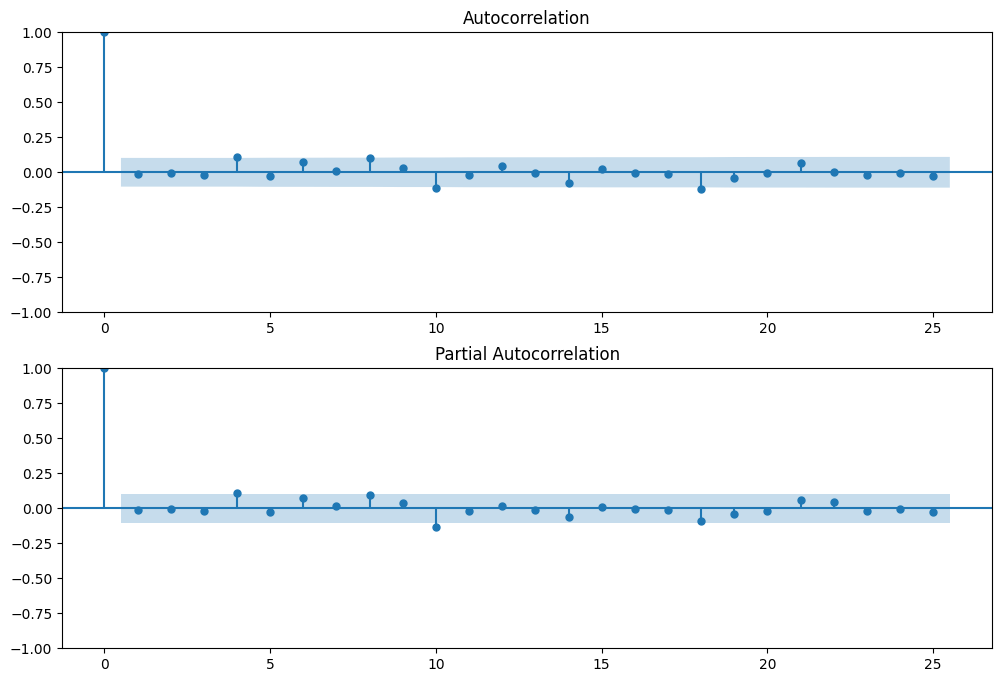

In [274]:
# Plot ACF dan PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Qty'], lags=25, ax=ax1)
plot_pacf(df['Qty'], lags=25, ax=ax2)
plt.show()

<Axes: xlabel='Date'>

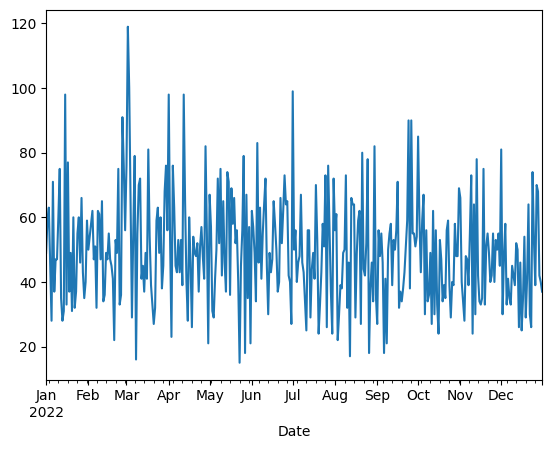

In [275]:
# Plotting data stasioner
df['Qty'].plot()

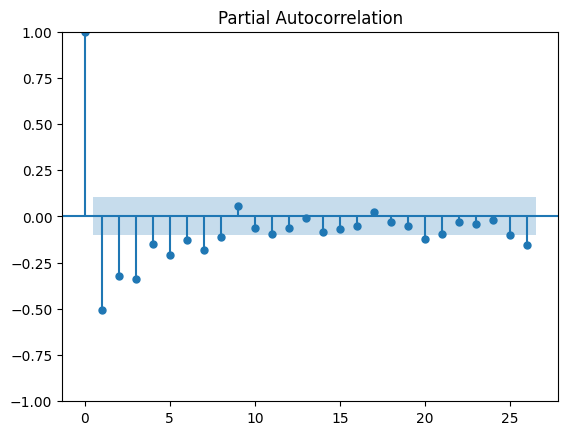

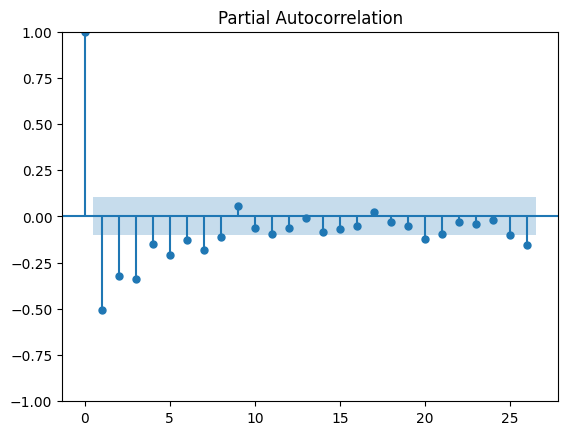

In [276]:
# Plot PACF untuk mencari nilai p
plot_pacf(df.Qty.diff().dropna())       # p = 1 karena lag pertama jauh di luar batas

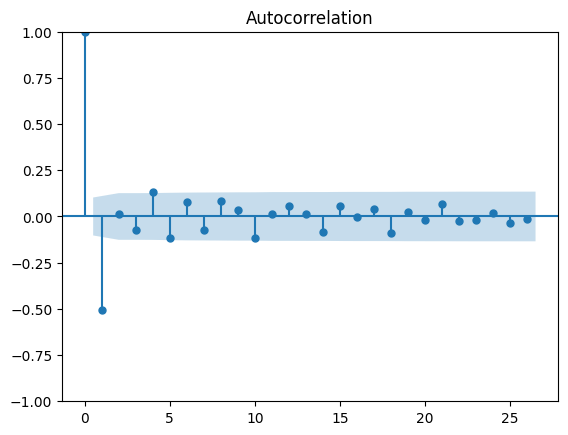

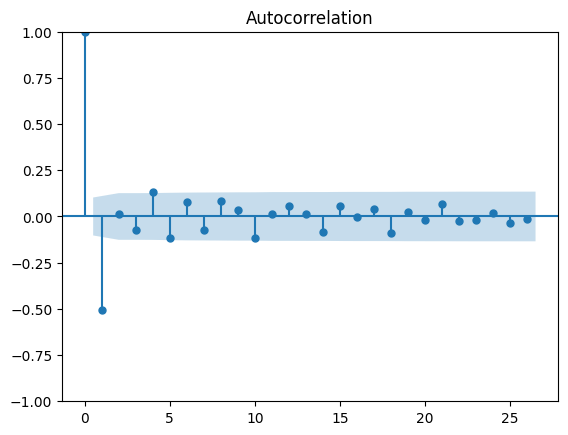

In [277]:
# Plot ACF untuk mencari nilai q
plot_acf(df.Qty.diff().dropna())        # q = 2 karena 2 lag berada di luar batas signifikansi

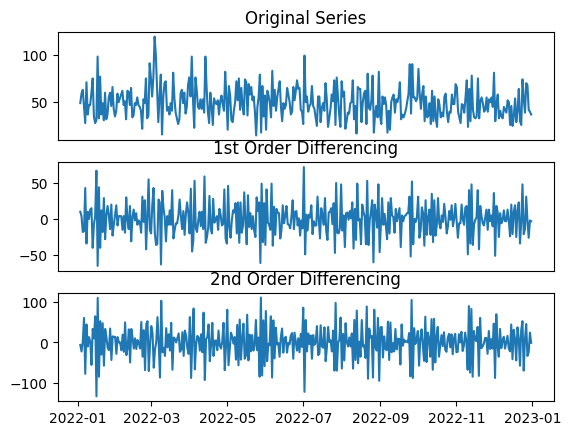

In [278]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df.Qty); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df.Qty.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df.Qty.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In [309]:
# Inisialisasi model ARIMA
p, d, q = 4, 0, 4 # Ganti dengan nilai yang sesuai analisis data yang telah dilakukan
model = ARIMA(train_data, order=(p, d, q))

# Latih model SARIMAX
model = model.fit()

d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Evaluation

In [311]:
# Lakukan prediksi pada data test
predictions = model.get_forecast(steps=len(test_data)).predicted_mean
# predictions = model_fit.forecast(steps=len(test_data))

In [312]:
# Membulatkan angka hasil prediksi
predictions.apply(lambda x: math.floor(x))

2022-09-13    50
2022-09-14    51
2022-09-15    56
2022-09-16    56
2022-09-17    50
              ..
2022-12-27    49
2022-12-28    50
2022-12-29    50
2022-12-30    51
2022-12-31    51
Freq: D, Name: predicted_mean, Length: 110, dtype: int64

In [300]:
# # Mengembalikan data yang dinormalisasi ke skala semula
# predictions_actual = scaler.inverse_transform(predictions.values.reshape(-1,1))
# test_actual = scaler.inverse_transform(test_data_normalized.values.reshape(-1,1))
# predictions_actual = scaler.inverse_transform(predictions.values.reshape(-1,1))

In [313]:
# Hitung Mean Squared Error
mse = mean_squared_error(test_data, predictions)

# Tampilkan hasil MSE
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 225.13830932424676


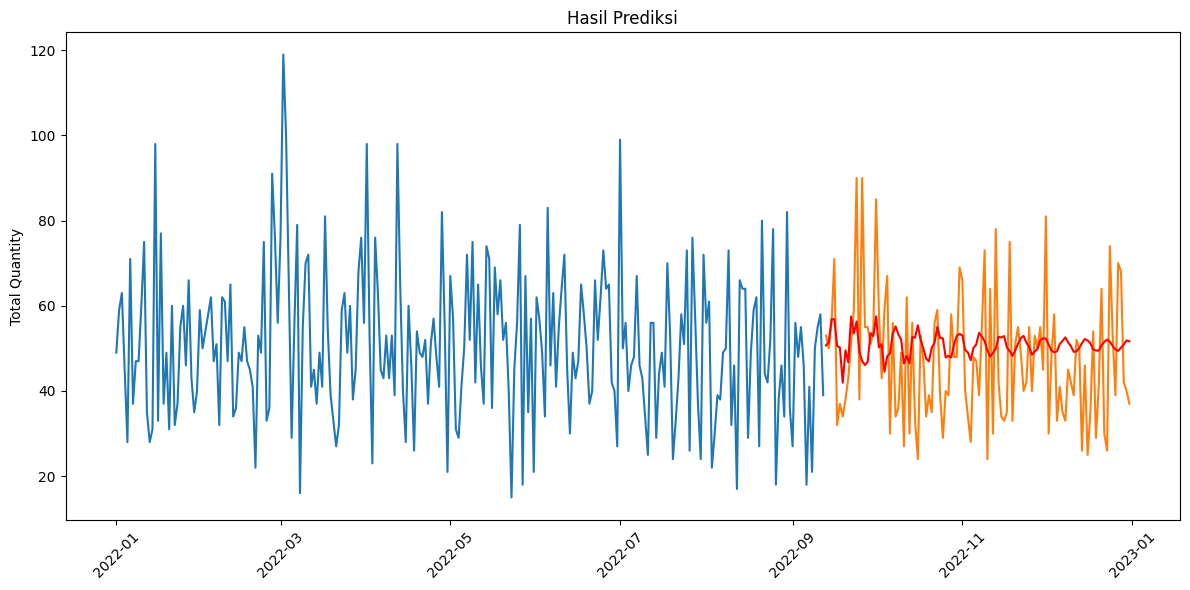

In [314]:
# Menampilkan grafik hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(train_data['Qty'])
plt.plot(test_data['Qty'])
plt.plot(predictions, color='red')
plt.title('Hasil Prediksi')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [303]:
# # Menampilkan grafik dari MSE untuk setiap product
# plt.figure(figsize=(10, 6))
# plt.bar(product_ids, mse_values)
# plt.xlabel('Product ID')
# plt.ylabel('Mean Squared Error (MSE)')
# plt.title('MSE for Each Product ID')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

## Auto Test

In [326]:
# Tentukan jumlah pengujian
n_tests = 100  # Ubah sesuai kebutuhan Anda

best_model = None
best_mse = float('inf')

for i in range(n_tests):
    # Acak nilai p dan q
    p = np.random.randint(1, 9)  # Ubah rentang nilai p sesuai kebutuhan Anda
    q = np.random.randint(1, 9)  # Ubah rentang nilai q sesuai kebutuhan Anda
    
    # Tetapkan d = 0
    d = 0
    
    try:
        # Latih model ARIMA
        model = ARIMA(train_data, order=(p, d, q))
        model_fit = model.fit()
        
        # Lakukan prediksi pada data pelatihan
        predictions = model_fit.get_forecast(steps=len(test_data)).predicted_mean
        
        # Membulatkan angka hasil prediksi
        predictions.apply(lambda x: math.floor(x))  
 
        # Menghitung Mean Squared Error (MSE) pada data pelatihan
        mse = mean_squared_error(test_data, predictions)
        
        # Memeriksa apakah ini model terbaik yang ditemukan sejauh ini
        if mse < best_mse:
            best_mse = mse
            best_model = model
        
        print(f"Iterasi {i+1}: p={p}, d={d}, q={q}, MSE={mse}")
    
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {str(e)}")

# Latih model terbaik pada seluruh data
# final_model = ARIMA(train_data, order=best_model.order)
# final_results = final_model.fit()

# Lakukan prediksi untuk masa depan
# forecast_steps = 10  # Ubah sesuai kebutuhan Anda
# forecast, stderr, conf_int = final_results.forecast(steps=forecast_steps)

# Tampilkan hasil prediksi
# print("Hasil Prediksi:")
# print(forecast)
print('-----------------------------------------------')
print('----------------------DONE---------------------')
print('-----------------------------------------------')

d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 1: p=8, d=0, q=2, MSE=233.0230720319703


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 2: p=3, d=0, q=1, MSE=232.64723163248365


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 3: p=7, d=0, q=6, MSE=242.44073003565026
Iterasi 4: p=1, d=0, q=4, MSE=232.62240959244525


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 5: p=7, d=0, q=1, MSE=232.3362776979446


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 6: p=5, d=0, q=5, MSE=231.39444291153544


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\

Iterasi 7: p=8, d=0, q=8, MSE=235.10023145782964


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 8: p=6, d=0, q=3, MSE=231.48310035207794


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\

Iterasi 9: p=3, d=0, q=6, MSE=230.01981288982626
Iterasi 10: p=4, d=0, q=2, MSE=232.66986612595113


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 11: p=7, d=0, q=5, MSE=233.62695301281104


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\

Iterasi 12: p=8, d=0, q=7, MSE=231.51668191317665


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 13: p=6, d=0, q=3, MSE=231.48310035207794
Iterasi 14: p=1, d=0, q=4, MSE=232.62240959244525
Iterasi 15: p=1, d=0, q=2, MSE=232.36848346580948


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

Iterasi 16: p=4, d=0, q=6, MSE=232.26244508480482
Iterasi 17: p=1, d=0, q=8, MSE=233.26072213338045


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\s

Iterasi 18: p=5, d=0, q=4, MSE=228.45955956301583


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\

Iterasi 19: p=3, d=0, q=8, MSE=231.41179255136518


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 20: p=6, d=0, q=4, MSE=229.36475549793607


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 21: p=6, d=0, q=6, MSE=237.25838766444267
Iterasi 22: p=2, d=0, q=4, MSE=232.52830269384162


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 23: p=3, d=0, q=4, MSE=233.34345618615563


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 24: p=8, d=0, q=3, MSE=233.33932395605677


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 25: p=8, d=0, q=7, MSE=231.51668191317665
Iterasi 26: p=8, d=0, q=2, MSE=233.0230720319703


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 27: p=8, d=0, q=6, MSE=239.32341882609063


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 28: p=6, d=0, q=8, MSE=239.8470499447182
Iterasi 29: p=1, d=0, q=2, MSE=232.36848346580948


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 30: p=4, d=0, q=7, MSE=232.62967035262935
Iterasi 31: p=3, d=0, q=1, MSE=232.64723163248365


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 32: p=2, d=0, q=8, MSE=231.8559369700559


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 33: p=5, d=0, q=5, MSE=231.39444291153544


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 34: p=7, d=0, q=4, MSE=232.6032875565755


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 35: p=4, d=0, q=5, MSE=227.32076640110586
Iterasi 36: p=5, d=0, q=1, MSE=233.08160547686043


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 37: p=7, d=0, q=7, MSE=237.38629790885292
Iterasi 38: p=1, d=0, q=4, MSE=232.62240959244525


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 39: p=3, d=0, q=1, MSE=232.64723163248365


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\s

Iterasi 40: p=3, d=0, q=2, MSE=232.56888949300816


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 41: p=6, d=0, q=8, MSE=239.8470499447182
Iterasi 42: p=2, d=0, q=8, MSE=231.8559369700559


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 43: p=1, d=0, q=7, MSE=231.81157506900666


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 44: p=4, d=0, q=1, MSE=233.01708764040296


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 45: p=5, d=0, q=7, MSE=240.50892477987406


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\

Iterasi 46: p=4, d=0, q=6, MSE=232.26244508480482


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 47: p=7, d=0, q=3, MSE=231.88777247911295


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 48: p=6, d=0, q=7, MSE=239.29899972228674


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 49: p=3, d=0, q=7, MSE=230.26301273608962


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 50: p=3, d=0, q=6, MSE=230.01981288982626
Iterasi 51: p=5, d=0, q=1, MSE=233.08160547686043


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 52: p=4, d=0, q=4, MSE=225.13830932424676
Iterasi 53: p=2, d=0, q=1, MSE=231.22519617394872


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 54: p=6, d=0, q=5, MSE=231.28092739588308


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\

Iterasi 55: p=3, d=0, q=8, MSE=231.41179255136518


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 56: p=6, d=0, q=3, MSE=231.48310035207794
Iterasi 57: p=8, d=0, q=2, MSE=233.0230720319703


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 58: p=2, d=0, q=2, MSE=227.72855672353583


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 59: p=7, d=0, q=6, MSE=242.44073003565026
Iterasi 60: p=7, d=0, q=1, MSE=232.3362776979446


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 61: p=7, d=0, q=8, MSE=231.30691236837887


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 62: p=7, d=0, q=8, MSE=231.30691236837887


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 63: p=6, d=0, q=5, MSE=231.28092739588308


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 64: p=8, d=0, q=5, MSE=235.66856167411825
Iterasi 65: p=7, d=0, q=1, MSE=232.3362776979446


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 66: p=8, d=0, q=7, MSE=231.51668191317665


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 67: p=7, d=0, q=8, MSE=231.30691236837887
Iterasi 68: p=8, d=0, q=1, MSE=234.06547021063426


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 69: p=8, d=0, q=2, MSE=233.0230720319703


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\s

Iterasi 70: p=7, d=0, q=3, MSE=231.88777247911295
Iterasi 71: p=4, d=0, q=3, MSE=232.57478690921852


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 72: p=7, d=0, q=7, MSE=237.38629790885292


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 73: p=4, d=0, q=7, MSE=232.62967035262935


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 74: p=6, d=0, q=6, MSE=237.25838766444267
Iterasi 75: p=2, d=0, q=7, MSE=232.45503226162367


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 76: p=2, d=0, q=6, MSE=232.36333050564707


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 77: p=2, d=0, q=7, MSE=232.45503226162367


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 78: p=3, d=0, q=3, MSE=232.61859915031857


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 79: p=1, d=0, q=5, MSE=232.66937560970507


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 80: p=5, d=0, q=7, MSE=240.50892477987406


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\

Iterasi 81: p=6, d=0, q=3, MSE=231.48310035207794


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 82: p=7, d=0, q=3, MSE=231.88777247911295


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 83: p=8, d=0, q=3, MSE=233.33932395605677


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 84: p=8, d=0, q=6, MSE=239.32341882609063
Iterasi 85: p=6, d=0, q=1, MSE=232.36335382377624


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 86: p=4, d=0, q=5, MSE=227.32076640110586


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 87: p=4, d=0, q=8, MSE=231.4925752864264
Iterasi 88: p=1, d=0, q=8, MSE=233.26072213338045


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 89: p=6, d=0, q=1, MSE=232.36335382377624


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_mo

Iterasi 90: p=5, d=0, q=6, MSE=240.29600523297626


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 91: p=4, d=0, q=4, MSE=225.13830932424676
Iterasi 92: p=4, d=0, q=1, MSE=233.01708764040296


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 93: p=5, d=0, q=1, MSE=233.08160547686043


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\s

Iterasi 94: p=5, d=0, q=4, MSE=228.45955956301583
Iterasi 95: p=3, d=0, q=3, MSE=232.61859915031857
Iterasi 96: p=2, d=0, q=1, MSE=231.22519617394872


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\s

Iterasi 97: p=4, d=0, q=7, MSE=232.62967035262935
Iterasi 98: p=5, d=0, q=2, MSE=232.83401520600248


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Iterasi 99: p=3, d=0, q=7, MSE=230.26301273608962
Iterasi 100: p=2, d=0, q=1, MSE=231.22519617394872
-----------------------------------------------
----------------------DONE---------------------
-----------------------------------------------


d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\statespace\

In [327]:
best_model.order

(4, 0, 4)

In [334]:
best_mse

225.13830932424676

d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Order: (4, 0, 4)
Mean Squared Error: 225.13830932424676


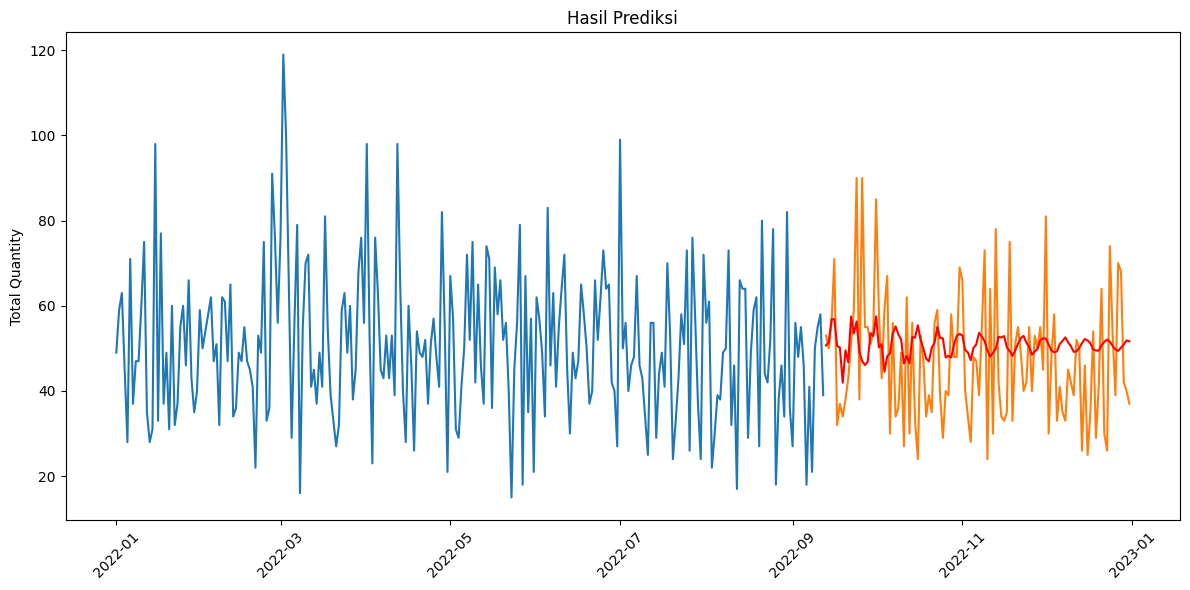

In [336]:
# Training & testing dengan best model
model = ARIMA(train_data, order=best_model.order)

# Latih model SARIMAX
model = model.fit()

# Lakukan prediksi pada data test
predictions = model.get_forecast(steps=len(test_data)).predicted_mean

# Membulatkan angka hasil prediksi
predictions.apply(lambda x: math.floor(x))

# Hitung Mean Squared Error
mse = mean_squared_error(test_data, predictions)

# Tampilkan hasil MSE
print()
print(f"Order: {best_model.order}")
print(f"Mean Squared Error: {mse}")

# Menampilkan grafik hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(train_data['Qty'])
plt.plot(test_data['Qty'])
plt.plot(predictions, color='red')
plt.title('Hasil Prediksi')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()